In [1]:
year=2019
month=6

In [2]:
import pandas as pd
import sys
sys.path.append('../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
%matplotlib inline

In [3]:
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and monthly_salary<80000 and YEAR(publish_date)={year} and MONTH(publish_date)={month}", con=db.get_conn())

In [6]:
data_original.shape

(83048, 94)

In [8]:
data = data_original

In [9]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [10]:
def get_sub_stats_by_prefix(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    salary_95_min=[]
    salary_95_max=[]
    count=[]
    
    features_out=[]
    for feature in features:
        #print(feature)
        idata=data[data[feature]==1]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(weighted.weighted_mean(values, weights))
        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_median.append(q[1])
        salary_95_min.append(q[0])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        features_out.append(feature)
    sub_data=pd.DataFrame()
    sub_data['rank']=range(0,len(features_out))
    sub_data[prefix]=[f.replace(prefix,'') for f in features_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)
    sub_data['rank']=range(1,len(features_out)+1)
    #sub_data=sub_data.reset_index()
    return sub_data

def apply_style(sub_data):
    return sub_data.style.hide_index().format(
        {"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}"})

In [11]:
data_pl=get_sub_stats_by_prefix(data,'pl_')

In [12]:
apply_style(data_pl)

rank,pl_,salary_mean,salary_median,salary_95_min,salary_95_max,head_count,percentage
1,julia,37500,37500,37500,37500,1,0.00%
2,haskell,26222,25000,7768,45000,45,0.01%
3,rust,18687,15000,5000,60000,248,0.07%
4,python,17982,16000,3750,45000,27847,7.60%
5,go,17612,15000,5250,40000,25515,6.96%
6,perl,17604,17500,5250,40000,2971,0.81%
7,matlab,17435,16666,5000,37500,5196,1.42%
8,lua,16902,15000,3750,45000,2698,0.74%
9,ruby,16200,15000,2500,34538,1091,0.30%
10,cpp,15349,12500,3750,37500,59314,16.18%


In [13]:
data_pl=data_pl[['pl_','percentage']].sort_values(by='percentage', ascending=False)
data_pl['rank']=range(1,22)
data_pl=data_pl[['rank','pl_','percentage']]
#data_pl.style.format({"percentage":"{:.2%}"})
data_pl.style.hide_index().format({"percentage":"{:.2%}"})

rank,pl_,percentage
1,java,33.46%
2,cpp,16.18%
3,c_sharp,13.01%
4,javascript,12.98%
5,python,7.60%
6,go,6.96%
7,php,4.64%
8,matlab,1.42%
9,perl,0.81%
10,swift,0.76%


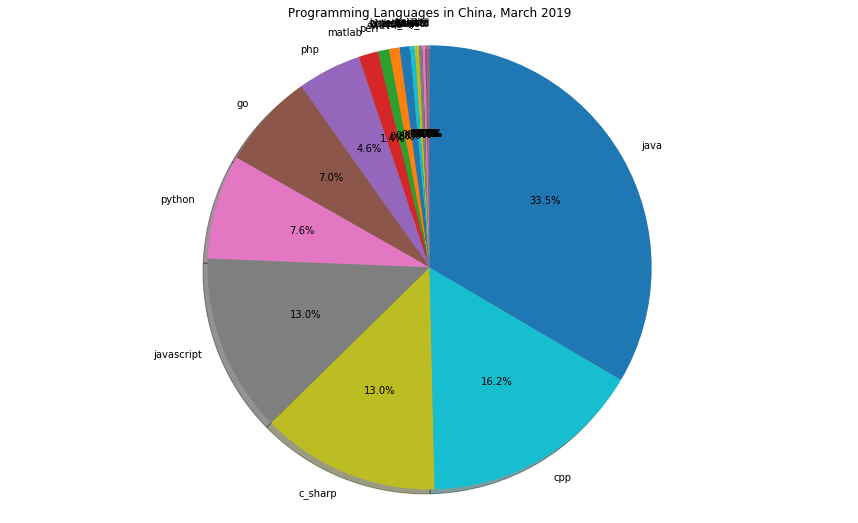

In [14]:
data_pl=data_pl.sort_values(by='percentage')

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = data_pl['pl_']
sizes = data_pl['percentage']
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(15, 9))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Programming Languages in China, March 2019")
plt.show()

## Word Cloud

In [15]:
from wordcloud import WordCloud

In [16]:
wc=WordCloud()

In [17]:
wc_dict = {}

In [18]:
for index, row in data_pl.iterrows():
    wc_dict[row['pl_']]=row['percentage']

In [19]:
wc=wc.generate_from_frequencies(wc_dict)

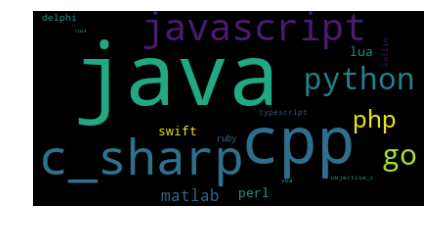

In [20]:
plt.figure(figsize=(7,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()